In [9]:
import os
import re
import time
from typing import Dict, Optional
from utils import get_api_key
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from models.llm_models import (
    MalnutritionPromptBuilder,
    extract_malnutrition_decision
)

In [10]:
def configure_deepseek_api():
    """Configure the DeepSeek API client"""
    return OpenAI(api_key=get_api_key("DEEPSEEK_API_KEY"),
                  base_url="https://api.deepseek.com")

def generate_text(prompt, model_name='deepseek-chat', temperature=0.0):
    """Generate text using the DeepSeek API.

    Args:
        prompt (str): The prompt to send to the model
        model_name (str): DeepSeek model name
        temperature (float): Generation temperature

    Returns:
        str: Model response
    """
    client = configure_deepseek_api()
    response = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant"},
            {"role": "user", "content": prompt},
        ],
        temperature=temperature,
        stream=False
    )
    return response.choices[0].message.content


def process_patient_data(
    data: pd.DataFrame,
    prompt_builder: MalnutritionPromptBuilder,
    text_col: str,
    id_col: Optional[str] = None,
    label_col: Optional[str] = None,
    temperature: float = 0.0,
    model_name: str = 'gemini-2.0-flash',
    few_shot_count: int = 0,
    balanced_examples: bool = True,
    stream_output: bool = False,
    max_retries: int = 3,
    retry_delay: int = 2
) -> pd.DataFrame:
    """Process patient data through Gemini API.

    Args:
        data (pd.DataFrame): DataFrame containing patient data
        prompt_builder (MalnutritionPromptBuilder): Prompt builder instance
        text_col (str): Column name containing patient notes
        id_col (Optional[str]): Column name for patient IDs
        label_col (Optional[str]): Column name for ground truth labels
        temperature (float): Generation temperature
        model_name (str): Gemini model name
        few_shot_count (int): Number of few-shot examples
        balanced_examples (bool): Whether to balance examples
        stream_output (bool): Whether to print results to console
        max_retries (int): Maximum number of API call retries
        retry_delay (int): Delay between retries in seconds

    Returns:
        pd.DataFrame: DataFrame with original data and predictions
    """
    # results = []

    # Create a copy of the dataframe with results columns
    result_df = data.copy()
    result_df['explanation'] = ""
    result_df['prediction'] = ""

    for idx, row in data.iterrows():
        patient_id = row[id_col] if id_col else idx
        patient_notes = row[text_col]
        ground_truth = row[label_col] if label_col else None

        if stream_output:
            print(f"\nProcessing patient {patient_id}...")

        # Get the prompt for this patient
        prompt = prompt_builder.get_inference_prompt(
            patient_notes=patient_notes,
            note_col=text_col,
            label_col=label_col,
            num_examples=few_shot_count,
            specific_example_indices=None,
            balanced=balanced_examples
        )

        # Call API with retries
        for attempt in range(max_retries):
            try:
                response = generate_text(
                    prompt=prompt,
                    model_name=model_name,
                    temperature=temperature
                )
                decision, explanation = extract_malnutrition_decision(response)

                # Store results
                result_df.at[idx, 'explanation'] = explanation
                result_df.at[idx, 'prediction'] = decision

                if stream_output:
                    print(f"Patient ID: {patient_id}")
                    print(f"Decision: {decision}")
                    print(f"Explanation: {explanation[:100]}...")
                    if ground_truth:
                        print(f"Ground Truth: {ground_truth}")
                    print("-" * 50)

                break
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"Error: {e}. Retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                else:
                    print(f"Error: {e}. Max retries reached.")
                    result_df.at[idx, 'explanation'] = f"Error: {str(e)}"
                    result_df.at[idx, 'prediction'] = "error"

    return result_df

In [11]:
def evaluate_results(
    results_df: pd.DataFrame,
    label_col: str,
    output_dir: str
) -> Dict:
    """Evaluate model performance when ground truth is available.

    Args:
        results_df (pd.DataFrame): DataFrame with predictions
        label_col (str): Column with ground truth labels
        output_dir (str): Directory to save evaluation results

    Returns:
        Dict: Evaluation metrics
    """
    # Convert labels for comparison
    def normalize_label(label):
        if isinstance(label, str) and label.lower() in ["yes", "true", "1",
                                                        "positive", "t"]:
            return "yes"
        elif isinstance(label, (int, float)) and label == 1:
            return "yes"
        return "no"
    # Filter out any rows with errors or unknown predictions
    valid_results = results_df[results_df['prediction'].isin(['yes', 'no'])]
    if len(valid_results) == 0:
        print("No valid predictions for evaluation.")
        return {}
    y_true = valid_results[label_col].apply(normalize_label)
    y_pred = valid_results['prediction']
    # Compute metrics
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred, labels=["yes", "no"])
    f1 = f1_score(y_true, y_pred, pos_label="yes")
    metrics = {
        'accuracy': report['accuracy'],
        'f1_score': f1,
        'precision': report['yes']['precision'],
        'recall': report['yes']['recall'],
        'confusion_matrix': cm.tolist(),
        'sample_count': len(valid_results)
    }
    # Generate visualizations
    os.makedirs(output_dir, exist_ok=True)
    # Confusion Matrix Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(["yes", "no"]))
    plt.xticks(tick_marks, ["yes", "no"])
    plt.yticks(tick_marks, ["yes", "no"])
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    # Metrics summary
    with open(os.path.join(output_dir, 'metrics_summary.txt'), 'w') as f:
        f.write(f"Model Evaluation Metrics\n")
        f.write(f"Sample Count: {metrics['sample_count']}\n")
        f.write(f"Accuracy: {metrics['accuracy']:.4f}\n")
        f.write(f"F1 Score: {metrics['f1_score']:.4f}\n")
        f.write(f"Precision: {metrics['precision']:.4f}\n")
        f.write(f"Recall: {metrics['recall']:.4f}\n")
        f.write("\nClassification Report:\n")
        f.write(classification_report(y_true, y_pred))

    return metrics

Loaded 10 examples from data/few_shot_example.csv
Loaded 20 patient records from data/test_labels.csv

Processing patient P137...
Patient ID: P137
Decision: yes
Explanation: 1) The patient is a 4-year-old male with severe food allergies and multiple food restrictions affect...
Ground Truth: yes
--------------------------------------------------

Processing patient P138...
Patient ID: P138
Decision: no
Explanation: 1) The patient is a 2-year-old female presenting for a well visit. Her weight-for-height z-score is ...
Ground Truth: no
--------------------------------------------------

Processing patient P139...
Patient ID: P139
Decision: yes
Explanation: 1) Explanation: The patient is a 3-year-old male with a BMI-for-age z-score of -2.8, which falls wit...
Ground Truth: yes
--------------------------------------------------

Processing patient P140...
Patient ID: P140
Decision: no
Explanation: 1) The patient is a 5-year-old female with a weight-for-height z-score of -0.5, which falls wi

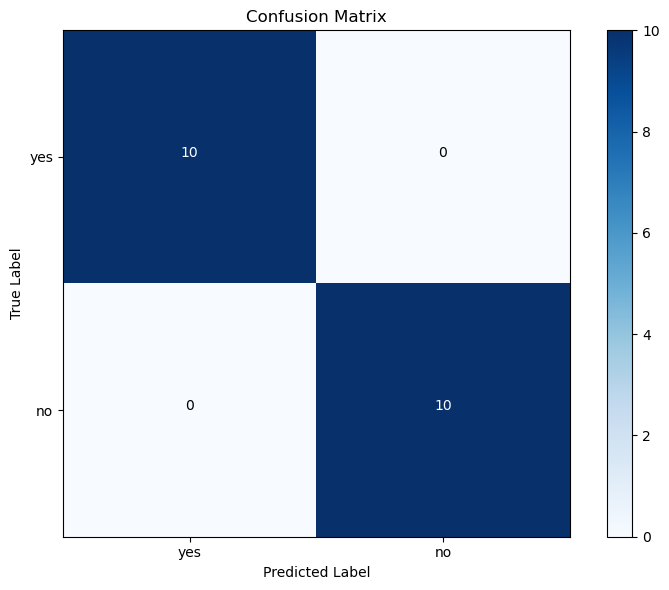

In [12]:
config = {
    "input": "data/test_labels.csv",
    "output_dir": "deepseek_output",
    "output": "results.csv",
    "text-col": "Note_Column",
    "id-col": "Patient_ID",
    "label-col": "Malnutrition_Label",
    "examples": "data/few_shot_example.csv",
    "few-shot-count": 0,
    "balanced-examples": True,
    "temperature": 0.0,
    "model": "deepseek-chat",
    "stream": True
}

# Create output directory
os.makedirs(config.get("output_dir", "gemini_output"), exist_ok=True)

# Initialize prompt builder
prompt_builder = MalnutritionPromptBuilder(
    examples_csv_path=config["examples"])

# Check if input is a file or text string
if os.path.isfile(config["input"]):
    # Read CSV file
    data = pd.read_csv(config["input"])
    print(f"Loaded {len(data)} patient records from {config['input']}")
else:
    # Treat as a single text string
    data = pd.DataFrame({config["text-col"]: [config["input"]]})
    if config["id-col"]:
        data[config["id-col"]] = ["single_patient"]
    print("Processing single text input")

# Process the data
results = process_patient_data(
    data=data,
    prompt_builder=prompt_builder,
    text_col=config["text-col"],
    id_col=config["id-col"],
    label_col=config["label-col"],
    temperature=config["temperature"],
    model_name=config["model"],
    few_shot_count=config["few-shot-count"],
    balanced_examples=config["balanced-examples"],
    stream_output=config["stream"]
)

# Save results to CSV
output_path = os.path.join(config["output_dir"], config["output"])
results.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

# Run evaluation if ground truth is available
if config["label-col"] and config["label-col"] in results.columns:
    print("Evaluating model performance...")
    metrics = evaluate_results(
        results_df=results,
        label_col=config["label-col"],
        output_dir=config["output_dir"]
    )
    if metrics:
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"F1 Score: {metrics['f1_score']:.4f}")
        print(f"Results and evaluation saved to {config['output_dir']}")